In [2]:
# while True:
# ping = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/%5ENSEI?range=3d&interval=1m').json()
# close = ping['chart']['result'][0]['indicators']['quote'][0]['close']
# timestamp = ping['chart']['result'][0]['timestamp']
# data_1 = pd.DataFrame({'Close': close, 'Time':timestamp})
# data_1['Time_b'] = [datetime.fromtimestamp(x) for x in data_1['Time']]
# data_1.drop('Time', axis=1,inplace=True)
# data_1.set_index('Time_b',inplace=True)

In [3]:
# !lscpu |grep 'Model name'
# !lscpu | grep 'Socket(s):'
# !lscpu | grep 'Core(s) per socket:'
# !lscpu | grep 'Thread(s) per core'
# !lscpu | grep "L3 cache" 
# !lscpu | grep "MHz"

In [4]:
import pandas as pd
from datetime import datetime
import time
import requests

In [5]:
data_1=pd.read_csv('Apple_2.csv')

In [6]:
 data_1=data_1.reset_index()

Load the required files before proceeding further:

In [7]:
df = data_1

In [8]:
%tensorflow_version 1.x
import helpermethods
import tensorflow as tf
import numpy as np
import sys
import os
from tensorflow.keras.layers import Dense, Input, RNN
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

TensorFlow 1.x selected.


In [9]:
print(tf.__version__)

1.15.2


In [10]:
#Import keras grnn
from rnn import FastGRNNCellKeras, FastRNNCellKeras

Data Preprocessing

In [11]:
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 

In [12]:
df = df[df['Close'].notna()]

In [13]:
data = pd.DataFrame()
data['Close']=df['Close']

In [14]:
count_nan = len(df) - df.count()
print(count_nan)

index     0
Time_b    0
Close     0
dtype: int64


In [15]:
print(data)

          Close
0    387.940002
1    388.350006
2    388.806702
3    389.459991
4    389.089996
..          ...
385  389.260010
386  389.250000
387  389.195007
388  389.049988
389  389.089996

[389 rows x 1 columns]


In [16]:
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset)- 50) 



#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [17]:

#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [18]:
# dataDimension = int(x_train.shape[1]) - 1
dataDimension = int(x_train.shape[1]) 
# print(dataDimension)

In [19]:
cell = "FastRNN" 
 
inputDims = 10 
hiddenDims = 50
 
totalEpochs = 40
batchSize = 10
 
learningRate = 0.001 #Change to 0.001,0.002,0.003 if -ve value of r^2 is obtained
decayStep = 50
decayRate = 0.1
 
outFile = None 
 
#low-rank parameterisation for weight matrices. None => Full Rank
wRank = None 
uRank = None 
 
# Sparsity of the weight matrices. x => 100*x % are non-zeros
# Note: Sparsity inducing is not supported in this code. 
sW = 1.0 
sU = 1.0
 
#Non-linearities for the RNN architecture. Can choose from "tanh, sigmoid, relu, quantTanh, quantSigm"
update_non_linearity = "relu"
gate_non_linearity = "relu"

In [20]:
assert dataDimension % inputDims == 0, "Infeasible per step input, Timesteps have to be integer"


In [21]:
cell == "FastRNN"
FastCell = FastRNNCellKeras(hiddenDims,update_non_linearity=update_non_linearity, wRank=wRank, uRank=uRank)

In [22]:
from tensorflow.keras import layers


Create Model

In [23]:
x = inputs = Input(shape=[int(dataDimension / inputDims), inputDims], name='input')
layer_shape = K.int_shape(x)#x.get_shape()
print(layer_shape)
x = RNN(FastCell, return_sequences=False, name='rnn')(x)


out = Dense(1, activation='relu', name='dense')(x)
model = Model(inputs=inputs, outputs=out)
Adam_ = Adam(lr=0.001)

model.compile(optimizer=Adam_, loss='mean_squared_error', metrics=['accuracy'])

model.summary()

(None, 1, 10)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 10)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 50)                3052      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,103
Trainable params: 3,103
Non-trainable params: 0
_________________________________________________________________


In [24]:
print(x_train.shape)
x_train = np.reshape(x_train,[x_train.shape[0],1,10])
print(x_test.shape)
x_test = np.reshape(x_test,[x_test.shape[0],1,10])
print(x_train.shape)
print(x_test.shape)

(329, 10, 1)
(50, 10, 1)
(329, 1, 10)
(50, 1, 10)


In [25]:
import time
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log_fastrnn.csv", append=True)


Using TensorFlow backend.


In [26]:
start = time.time()
model.fit(x_train, y_train, batchSize, epochs=totalEpochs, validation_data=(x_test, scaled_data[training_data_len : , : ]), callbacks=[csv_logger])
stop = time.time()
print(f"Training time: {stop - start}s")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 2ms/sample - loss: 0.0670 - acc: 0.0030 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 2/40
329/329 [==============================] - 0s 276us/sample - loss: 0.0343 - acc: 0.0030 - val_loss: 0.0096 - val_acc: 0.0000e+00
Epoch 3/40
329/329 [==============================] - 0s 315us/sample - loss: 0.0277 - acc: 0.0030 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 4/40
329/329 [==============================] - 0s 242us/sample - loss: 0.0243 - acc: 0.0061 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 5/40
329/329 [==============================] - 0s 243us/sample - loss: 0.0211 - acc: 0.0061 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 6/40
329/329 [==============================] - 0s 319us/sample - loss: 0.0181 - acc: 0.0061 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 7/40
329/329 [===

In [27]:
performance_log_fastrnn=pd.read_csv('model_history_log_fastrnn.csv')

In [28]:
time_fastrnn= stop-start
print(time_fastrnn)

4.929312467575073


Finding MSE


In [29]:
# Getting the models predicted price values
 
predictions_fastgrnn = model.predict(x_test)
predictions_fastgrnn = scaler.inverse_transform(predictions_fastgrnn)#Undo scaling
#Calculate/Get the value of RMSE

mse_fastgrnn= mean_squared_error(y_test, predictions_fastgrnn )
rmse_fastgrnn = math.sqrt(mse_fastgrnn)
print(rmse_fastgrnn)


0.27055256889899304


In [30]:
from sklearn.metrics import r2_score

cod_fastrnn = r2_score(y_test, predictions_fastgrnn)
print(cod_fastrnn)

0.7714156062623501


#####################################LSTM

In [104]:
# print(data_1)
data_1=pd.read_csv('Apple_2.csv')

In [105]:
df = data_1
data_2 = df.filter(['Close'])
# len(data_2)
data_2 = data_2[data_2['Close'].notna()]
# len(data_2)

In [106]:


#Converting the dataframe to a numpy array
dataset = data_2.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) -50) 
# training_data_len = math.ceil( len(dataset) *.6)




#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [107]:
#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [117]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

In [118]:


#Build the LSTM network model
model_lstm = Sequential()
model_lstm.add(LSTM(units=1, return_sequences=False,input_shape=(x_train.shape[1],1)))
# model_lstm.add(LSTM(units=50, return_sequences=False))
# model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))


#Compile the model
model_lstm.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')


In [119]:
csv_logger_lstm = CSVLogger("model_history_log_lstm.csv", append=True)


In [120]:
start_lstm = time.time()
 
#Train the model
model_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_lstm]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 4ms/step - loss: 0.1525 - val_loss: 0.1038
Epoch 2/40
329/329 [==============================] - 0s 463us/step - loss: 0.1304 - val_loss: 0.0845
Epoch 3/40
329/329 [==============================] - 0s 465us/step - loss: 0.1120 - val_loss: 0.0683
Epoch 4/40
329/329 [==============================] - 0s 750us/step - loss: 0.0962 - val_loss: 0.0532
Epoch 5/40
329/329 [==============================] - 0s 664us/step - loss: 0.0813 - val_loss: 0.0393
Epoch 6/40
329/329 [==============================] - 0s 684us/step - loss: 0.0675 - val_loss: 0.0265
Epoch 7/40
329/329 [==============================] - 0s 522us/step - loss: 0.0544 - val_loss: 0.0173
Epoch 8/40
329/329 [==============================] - 0s 513us/step - loss: 0.0455 - val_loss: 0.0124
Epoch 9/40
329/329 [==============================] - 0s 600us/step - loss: 0.0410 - val_loss: 0.0113
Epoch 10/40
329/329 [==================

In [121]:
performance_log_lstm=pd.read_csv('model_history_log_lstm.csv')

In [122]:
time_lstm_1=stop_lstm-start_lstm

In [123]:
#Getting the models predicted price values
predictions_lstm = model_lstm.predict(x_test) 
predictions_lstm = scaler.inverse_transform(predictions_lstm)#Undo scaling

#Calculate/Get the value of RMSE
rmse_lstm_1=np.sqrt(np.mean(((predictions_lstm- y_test)**2)))
print(rmse_lstm_1)

0.31237730198357905


In [124]:

cod_lstm_1 = r2_score(y_test, predictions_lstm)
print(cod_lstm_1)

0.6952791356431234


In [116]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['FastGRNN'] = predictions_fastgrnn
valid['LSTM'] = predictions_lstm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
valid = valid.reset_index(drop=True)

##FB Prophet


In [45]:
from fbprophet import Prophet

In [46]:
df_fb=df
df_fb['Time_b'] = pd.to_datetime(df_fb.Time_b,format='%Y-%m-%d')
df_fb.index = df_fb['Time_b']

In [47]:
#preparing data
df_fb.rename(columns={'Close': 'y', 'Time_b': 'ds'}, inplace=True)

#train and validation
train_fb = df_fb[:training_data_len]
valid_fb = df_fb[training_data_len:]

#fit the model
model_fb = Prophet(daily_seasonality=True)#,yearly_seasonality=True)


start_fb=time.time()
model_fb.fit(train_fb)
stop_fb = time.time()
print(f"Training time: {stop_fb - start_fb}s")



#predictions
close_prices_fb = model_fb.make_future_dataframe(periods=len(valid_fb), freq='1min')
forecast_fb = model_fb.predict(close_prices_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Training time: 0.5923831462860107s


In [48]:
time_fb=stop_fb-start_fb
print(time_fb)
#rmse
forecast_valid_fb = forecast_fb['yhat'][training_data_len:]
# predictions_fb=scaler.inverse_transform(np.array(forecast_valid_fb).reshape(-1,1))
predictions_fb=np.array(forecast_valid_fb).reshape(-1,1)
predictions_fb=predictions_fb[:-1]
rmse_fb=np.sqrt(np.mean(np.power((np.array(valid_fb['y'])-np.array(forecast_valid_fb)),2)))
print(rmse_fb)
cod_fb = r2_score((valid_fb['y']), (forecast_valid_fb))
print(cod_fb)

0.5923831462860107
1.8642244688966214
-9.901839196937376


In [49]:
fb_pred_df = pd.DataFrame({'FB_Prophet Predictions':np.array(forecast_valid_fb)})
valid['FB_Prophet']=fb_pred_df['FB_Prophet Predictions']

In [50]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

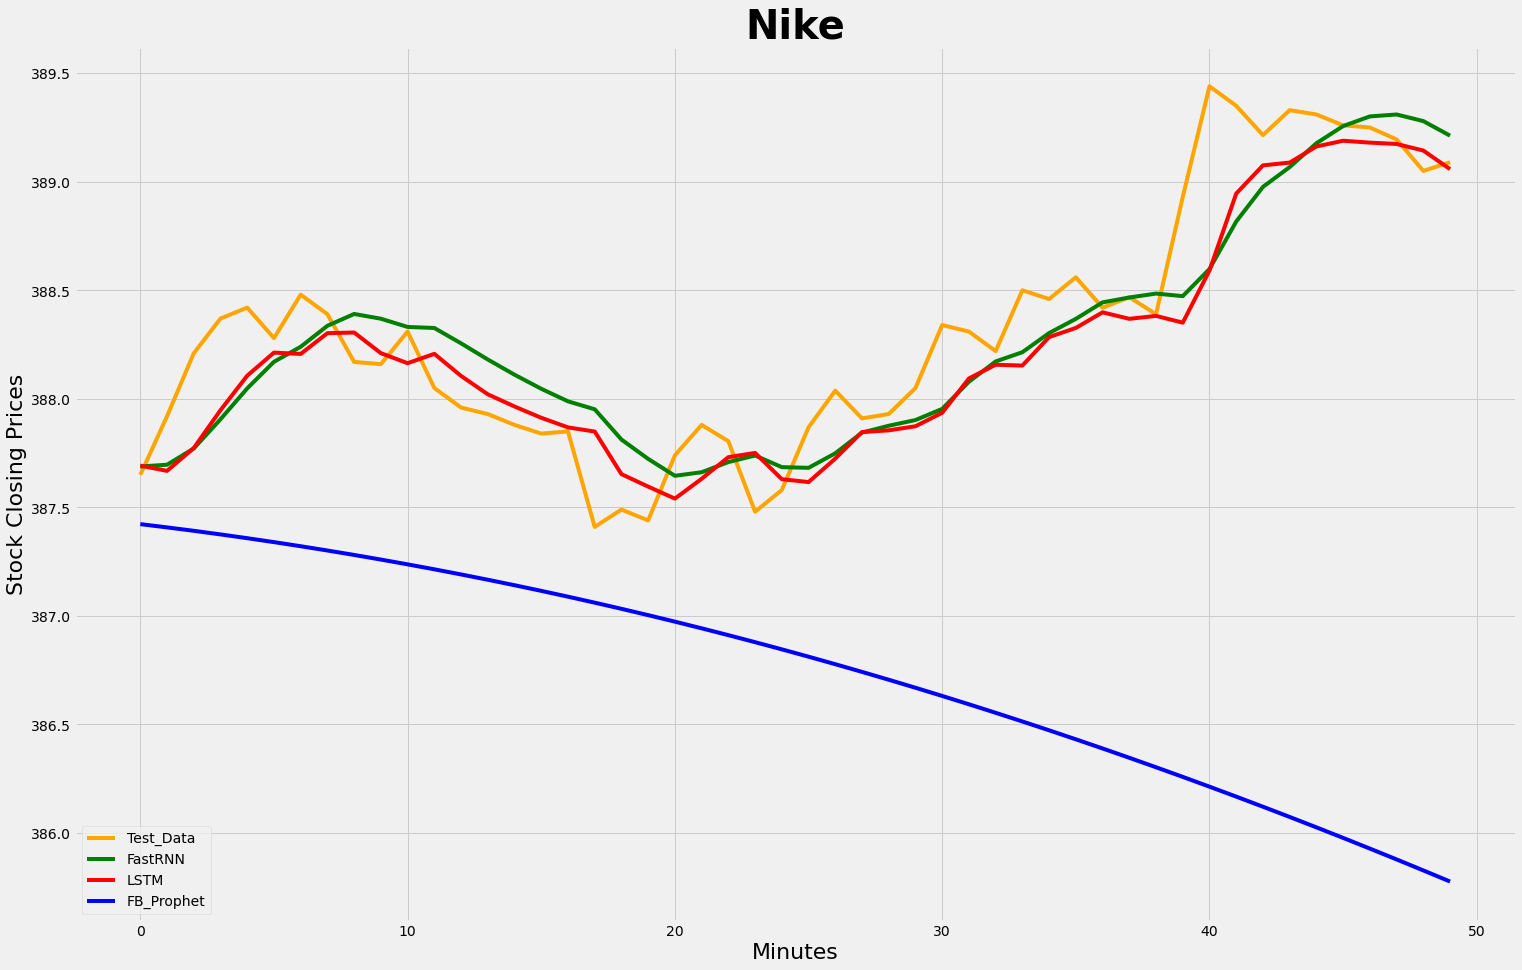

In [51]:
#Visualize the data
plt.figure(figsize=(23,15))
plt.title('Nike',fontweight='bold',fontsize=40)
plt.xlabel('Minutes', fontsize=22)
plt.ylabel("Stock Closing Prices", fontsize=22)
# plt.plot(train['Close'], color='green')
 
 
plt.plot(valid[['Close']], color= 'orange', label='Test_Data')
plt.plot(valid[['FastGRNN']],color = 'green',label='FastRNN')
plt.plot(valid[['LSTM']],color = 'red',label='LSTM')
plt.plot(valid[['FB_Prophet']],color = 'blue',label='FB_Prophet')

 
plt.legend( loc='lower left')
plt.savefig('plot_predicted.png')

In [52]:
print(time_lstm_1)
print(time_fastrnn)
print(time_fb)

7.1074652671813965
4.929312467575073
0.5923831462860107


In [53]:
df_final = pd.DataFrame(columns=['Model_name','RMSE','Time(in sec)','R-Square value'])

In [54]:
df_final.loc[0] = pd.Series({'Model_name': str('FastRNN'),'RMSE':rmse_fastgrnn ,'Time(in sec)':time_fastrnn,'Description':str('-'),'R-Square value': cod_fastrnn})
df_final.loc[1] = pd.Series({'Model_name': str('LSTM'),'RMSE':rmse_lstm_1 ,'Time(in sec)':time_lstm_1,'Description':str('-'),'R-Square value':cod_lstm_1})
df_final.loc[2] = pd.Series({'Model_name': str('FB_Prophet'),'RMSE':rmse_fb ,'Time(in sec)':time_fb,'Description':str('-'),'R-Square value':cod_fb})

In [55]:
print(df_final)
df_final.to_csv('nike_performance_results.csv', index=False)

   Model_name      RMSE  Time(in sec)  R-Square value
0     FastRNN  0.270553      4.929312        0.771416
1        LSTM  0.250038      7.107465        0.804766
2  FB_Prophet  1.864224      0.592383       -9.901839


In [56]:
df_final

,Model_name,RMSE,Time(in sec),R-Square value
0,FastRNN,0.270553,4.929312,0.771416
1,LSTM,0.250038,7.107465,0.804766
2,FB_Prophet,1.864224,0.592383,-9.901839


# New Section

In [57]:
predicted_results = pd.DataFrame(columns=['Test_Data','FastRNN'  ,'LSTM'  ,'FB_Prophet' ])

In [58]:
predicted_results['Test_Data']=np.squeeze(y_test)
predicted_results['FastRNN']=np.squeeze(predictions_fastgrnn)
predicted_results['LSTM']=np.squeeze(predictions_lstm)
predicted_results['FB_Prophet']=np.squeeze(predictions_fb)


In [59]:
predicted_results.head()

,Test_Data,FastRNN,LSTM,FB_Prophet
0,387.649994,387.688446,387.692505,387.422984
1,387.920013,387.696594,387.668274,387.407951
2,388.209991,387.771423,387.773529,387.392147
3,388.369995,387.906067,387.947906,387.375569
4,388.420288,388.048340,388.106720,387.358215


In [60]:
predicted_results.to_csv('Predicted_Values.csv', index=False)